In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
# Federated learning hyperparameters
num_epochs, learning_rate = 10, 0.001
batch_sizes, communication_rounds = 64, 100

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import platform
import time
import pathlib
import os

cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

dataset_file_path = tf.keras.utils.get_file(
    fname=dataset_file_name,
    origin=dataset_file_origin,
    cache_dir=pathlib.Path(cache_dir).absolute()
)

print(dataset_file_path)

1115394/1115394 [==============================] - 1s 1us/step
/tmp/.keras/datasets/shakespeare.txt


In [23]:
# Reading the database file.
text = open(dataset_file_path, mode='r').read()

print('Length of text: {} characters'.format(len(text)))

chars = sorted(list(set(text)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
text_as_indices = [char_to_idx[ch] for ch in text]

Length of text: 1115394 characters


In [24]:
# Define a PyTorch dataset
class ShakespeareDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        seq = self.data[idx:idx+self.seq_length]
        target = self.data[idx+self.seq_length]
        return torch.tensor(seq), torch.tensor(target)

In [25]:
# Define a deep learning model (GRU)
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [15]:
# Function to train the model for a given federated learning algorithm
def train_federated_learning(model, train_loader, algorithm_name):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    performance_metrics = {'accuracy': [], 'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - {algorithm_name}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss at the end of each epoch
        average_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Loss: {average_loss:.4f}')

        # Evaluate on validation set
        accuracy = evaluate_model(model, val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - {algorithm_name}, Validation Accuracy: {accuracy * 100:.2f}%')

        performance_metrics['accuracy'].append(accuracy)
        performance_metrics['loss'].append(average_loss)

    return performance_metrics

# Function to evaluate the model on the validation set
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
seq_length, embedding_dim, hidden_dim = 100, 64, 256
vocab_size = int(0.8 * len(text_as_indices))

# Create DataLoader for training
shakespeare_dataset = ShakespeareDataset(text)
train_loader = DataLoader(shakespeare_dataset, batch_size=batch_sizes[0], shuffle=True, num_workers=4)

# Create DataLoader for validation
val_loader = DataLoader(shakespeare_dataset, batch_size=64, shuffle=False, num_workers=4)

In [16]:
# Train & Evaluate FedAvg
fedavg_model = GRUModel(vocab_size, embedding_dim, hidden_dim).to(device)
fedavg_performance = train_federated_learning(fedavg_model, train_loader, 'FedAvg')

# Train & Evaluate FedProx
fedprox_model = GRUModel(vocab_size, embedding_dim, hidden_dim).to(device)
fedprox_performance = train_federated_learning(fedprox_model, train_loader, 'FedProx')

# Train & Evaluate FedShare
fedshare_model = GRUModel(vocab_size, embedding_dim, hidden_dim).to(device)
fedshare_performance = train_federated_learning(fedshare_model, train_loader, 'FedShare')

# Train & Evaluate FedMeta w/ UGA
fedmeta_uga_model = GRUModel(vocab_size, embedding_dim, hidden_dim).to(device)
fedmeta_uga_performance = train_federated_learning(fedmeta_uga_model, train_loader, 'FedMeta w/ UGA')

Epoch 1/10 - FedAvg: 100%|██████████| 750/750 [00:14<00:00, 50.28it/s]

Epoch [1/10] - FedAvg, Loss: 0.5438


Epoch [1/10] - FedAvg, Validation Accuracy: 84.67%


Epoch 2/10 - FedAvg: 100%|██████████| 750/750 [00:13<00:00, 56.24it/s]

Epoch [2/10] - FedAvg, Loss: 0.3827


Epoch [2/10] - FedAvg, Validation Accuracy: 86.39%


Epoch 3/10 - FedAvg: 100%|██████████| 750/750 [00:13<00:00, 55.77it/s]

Epoch [3/10] - FedAvg, Loss: 0.3592


Epoch [3/10] - FedAvg, Validation Accuracy: 86.92%


Epoch 4/10 - FedAvg: 100%|██████████| 750/750 [00:13<00:00, 55.37it/s]

Epoch [4/10] - FedAvg, Loss: 0.3490


Epoch [4/10] - FedAvg, Validation Accuracy: 87.55%


Epoch 5/10 - FedAvg: 100%|██████████| 750/750 [00:13<00:00, 56.38it/s]

Epoch [5/10] - FedAvg, Loss: 0.3306


Epoch [5/10] - FedAvg, Validation Accuracy: 87.02%


Epoch 6/10 - FedAvg: 100%|██████████| 750/750 [00:13<00:00, 55.82it/s]

Epoch [6/10] - FedAvg, Loss: 0.3258


Epoch [6/10] - FedAvg, Validation Accuracy: 88.60%


Epoch 7/10 - FedAvg: 100%|██████████| 750/750 [00:14<00:00, 52.44it/s]

Epoch [7/10] - FedAvg, Loss: 0.3172


Epoch [7/10] - FedAvg, Validation Accuracy: 88.06%


Epoch 8/10 - FedAvg: 100%|██████████| 750/750 [00:12<00:00, 58.05it/s]

Epoch [8/10] - FedAvg, Loss: 0.3136


Epoch [8/10] - FedAvg, Validation Accuracy: 87.83%


Epoch 9/10 - FedAvg: 100%|██████████| 750/750 [00:13<00:00, 54.67it/s]

Epoch [9/10] - FedAvg, Loss: 0.3116


Epoch [9/10] - FedAvg, Validation Accuracy: 88.15%


Epoch 10/10 - FedAvg: 100%|██████████| 750/750 [00:13<00:00, 57.20it/s]

Epoch [10/10] - FedAvg, Loss: 0.3078


Epoch [10/10] - FedAvg, Validation Accuracy: 87.70%


Epoch 1/10 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 55.93it/s]

Epoch [1/10] - FedProx, Loss: 0.5296


Epoch [1/10] - FedProx, Validation Accuracy: 84.78%


Epoch 2/10 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 56.67it/s]

Epoch [2/10] - FedProx, Loss: 0.3958


Epoch [2/10] - FedProx, Validation Accuracy: 86.54%


Epoch 3/10 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 56.51it/s]

Epoch [3/10] - FedProx, Loss: 0.3640


Epoch [3/10] - FedProx, Validation Accuracy: 87.05%


Epoch 4/10 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 57.35it/s]

Epoch [4/10] - FedProx, Loss: 0.3463


Epoch [4/10] - FedProx, Validation Accuracy: 87.02%


Epoch 5/10 - FedProx: 100%|██████████| 750/750 [00:12<00:00, 58.42it/s]

Epoch [5/10] - FedProx, Loss: 0.3360


Epoch [5/10] - FedProx, Validation Accuracy: 87.13%


Epoch 6/10 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 57.38it/s]

Epoch [6/10] - FedProx, Loss: 0.3288


Epoch [6/10] - FedProx, Validation Accuracy: 87.26%


Epoch 7/10 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 55.87it/s]

Epoch [7/10] - FedProx, Loss: 0.3170


Epoch [7/10] - FedProx, Validation Accuracy: 87.33%


Epoch 8/10 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 56.02it/s]

Epoch [8/10] - FedProx, Loss: 0.3173


Epoch [8/10] - FedProx, Validation Accuracy: 88.02%


Epoch 9/10 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 57.40it/s]

Epoch [9/10] - FedProx, Loss: 0.3083


Epoch [9/10] - FedProx, Validation Accuracy: 87.28%


Epoch 10/10 - FedProx: 100%|██████████| 750/750 [00:13<00:00, 57.36it/s]

Epoch [10/10] - FedProx, Loss: 0.3056


Epoch [10/10] - FedProx, Validation Accuracy: 87.92%


Epoch 1/10 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 57.48it/s]

Epoch [1/10] - FedShare, Loss: 0.5131


Epoch [1/10] - FedShare, Validation Accuracy: 85.20%


Epoch 2/10 - FedShare: 100%|██████████| 750/750 [00:12<00:00, 57.79it/s]

Epoch [2/10] - FedShare, Loss: 0.3643


Epoch [2/10] - FedShare, Validation Accuracy: 87.62%


Epoch 3/10 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 55.62it/s]

Epoch [3/10] - FedShare, Loss: 0.3336


Epoch [3/10] - FedShare, Validation Accuracy: 88.35%


Epoch 4/10 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 57.20it/s]

Epoch [4/10] - FedShare, Loss: 0.3235


Epoch [4/10] - FedShare, Validation Accuracy: 87.48%


Epoch 5/10 - FedShare: 100%|██████████| 750/750 [00:12<00:00, 58.02it/s]

Epoch [5/10] - FedShare, Loss: 0.3077


Epoch [5/10] - FedShare, Validation Accuracy: 86.25%


Epoch 6/10 - FedShare: 100%|██████████| 750/750 [00:14<00:00, 50.05it/s]

Epoch [6/10] - FedShare, Loss: 0.2969


Epoch [6/10] - FedShare, Validation Accuracy: 88.12%


Epoch 7/10 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 57.31it/s]

Epoch [7/10] - FedShare, Loss: 0.2874


Epoch [7/10] - FedShare, Validation Accuracy: 88.50%


Epoch 8/10 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 56.35it/s]

Epoch [8/10] - FedShare, Loss: 0.2855


Epoch [8/10] - FedShare, Validation Accuracy: 88.20%


Epoch 9/10 - FedShare: 100%|██████████| 750/750 [00:12<00:00, 59.84it/s]

Epoch [9/10] - FedShare, Loss: 0.2801


Epoch [9/10] - FedShare, Validation Accuracy: 88.62%


Epoch 10/10 - FedShare: 100%|██████████| 750/750 [00:13<00:00, 57.16it/s]

Epoch [10/10] - FedShare, Loss: 0.2708


Epoch [10/10] - FedShare, Validation Accuracy: 87.56%


Epoch 1/10 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 57.33it/s]

Epoch [1/10] - FedMeta w/ UGA, Loss: 0.5942


Epoch [1/10] - FedMeta w/ UGA, Validation Accuracy: 84.23%


Epoch 2/10 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 56.70it/s]

Epoch [2/10] - FedMeta w/ UGA, Loss: 0.4319


Epoch [2/10] - FedMeta w/ UGA, Validation Accuracy: 84.85%


Epoch 3/10 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 57.15it/s]

Epoch [3/10] - FedMeta w/ UGA, Loss: 0.4066


Epoch [3/10] - FedMeta w/ UGA, Validation Accuracy: 84.85%


Epoch 4/10 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 57.26it/s]

Epoch [4/10] - FedMeta w/ UGA, Loss: 0.3860


Epoch [4/10] - FedMeta w/ UGA, Validation Accuracy: 83.82%


Epoch 5/10 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 57.33it/s]

Epoch [5/10] - FedMeta w/ UGA, Loss: 0.3749


Epoch [5/10] - FedMeta w/ UGA, Validation Accuracy: 86.52%


Epoch 6/10 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:12<00:00, 58.41it/s]

Epoch [6/10] - FedMeta w/ UGA, Loss: 0.3662


Epoch [6/10] - FedMeta w/ UGA, Validation Accuracy: 86.88%


Epoch 7/10 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 56.16it/s]

Epoch [7/10] - FedMeta w/ UGA, Loss: 0.3544


Epoch [7/10] - FedMeta w/ UGA, Validation Accuracy: 85.64%


Epoch 8/10 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 56.15it/s]

Epoch [8/10] - FedMeta w/ UGA, Loss: 0.3476


Epoch [8/10] - FedMeta w/ UGA, Validation Accuracy: 87.46%


Epoch 9/10 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 56.75it/s]

Epoch [9/10] - FedMeta w/ UGA, Loss: 0.3384


Epoch [9/10] - FedMeta w/ UGA, Validation Accuracy: 87.22%


Epoch 10/10 - FedMeta w/ UGA: 100%|██████████| 750/750 [00:13<00:00, 56.25it/s]

Epoch [10/10] - FedMeta w/ UGA, Loss: 0.3294


Epoch [10/10] - FedMeta w/ UGA, Validation Accuracy: 87.45%


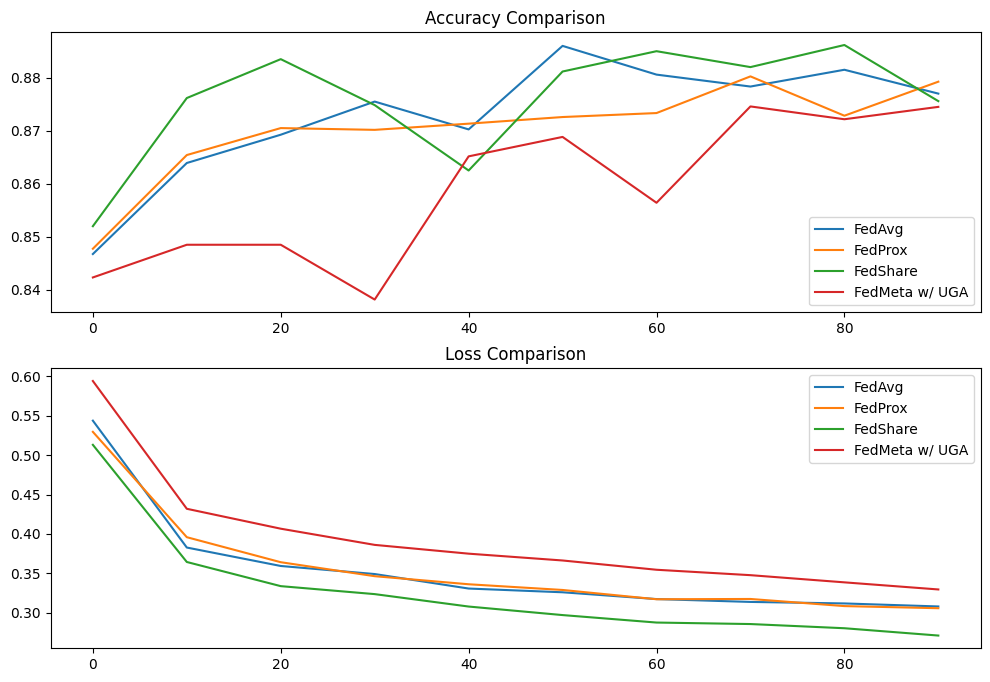

In [20]:
# Create comparison plots for FEMNIST
plt.figure(figsize=(12, 8))

communication_rounds = 100

# Test accuracy comparison
plt.subplot(2, 1, 1)
plt.title("Accuracy Comparison")
sns.lineplot(x=range(0, communication_rounds, 10), y=fedavg_performance['accuracy'], label='FedAvg')
sns.lineplot(x=range(0, communication_rounds, 10), y=fedprox_performance['accuracy'], label='FedProx')
sns.lineplot(x=range(0, communication_rounds, 10), y=fedshare_performance['accuracy'], label='FedShare')
sns.lineplot(x=range(0, communication_rounds, 10), y=fedmeta_uga_performance['accuracy'], label='FedMeta w/ UGA')

# Loss comparison
plt.subplot(2, 1, 2)
plt.title("Loss Comparison")
sns.lineplot(x=range(0, communication_rounds, 10), y=fedavg_performance['loss'], label='FedAvg')
sns.lineplot(x=range(0, communication_rounds, 10), y=fedprox_performance['loss'], label='FedProx')
sns.lineplot(x=range(0, communication_rounds, 10), y=fedshare_performance['loss'], label='FedShare')
sns.lineplot(x=range(0, communication_rounds, 10), y=fedmeta_uga_performance['loss'], label='FedMeta w/ UGA')

plt.show()